# Demo notebook for Niimpy Exploration layer modules

## Introduction <a class="anchor" id="section_0"></a>

To study and quantify human behavior using longitudinal multimodal digital data, it is essential to get to know the data well first. These data from various sources or sensors, such as smartphones and watches and activity trackers, yields data with different types and properties. The data may be a mixture of categorical, ordinal and numerical data, typically consisting of time series measured for multiple subjetcs from different groups. While the data is typically dense, it is also heterogenous and contains lots of missing values. Therefore, the analysis has to be conducted on many different levels.  

This notebook introduces the Niimpy toolbox exploration module, which seeks to address the aforementioned issues. The module has functionalities for exploratory data analysis (EDA) of digital behavioral data. The module aims to produce a summary of the data characteristics, inspecting the structures underlying the data, to detecting patterns and changes in the patterns, and to assess the data quality (e.g., missing data, outliers). This information is highly essential for assessing data validity, data filtering and selection, and for data preprocessing. The module includes functions for [plotting catogorical data](#section_1), [data counts](#section_2), [timeseries lineplots](#section_3), [punchcards](#section_4) and [visualizing missing data.](#section_5)

Exploration module functions are supposed to run after [data preprocessing](https://niimpy.readthedocs.io/en/latest/preprocessing/), but they can be run also on the raw observations.
All the functions are implemented by using [Plotly Python Open sourde Library](https://plotly.com/python/). Plotly enables interactive visualizations which in turn makers it easier to explore different aspects of the data (e.g.,specific timerange and summary statistics).

This notebook uses several sample dataframes for module demonstration. The sample data is already preprocessed, or will be preprocessed in notebook sections before visualizations. When the sample data is loaded, some of the key characteristics of the data are displayed. 

All eploration module functions require the data to follow [data schema.](https://niimpy.readthedocs.io/en/latest/schema/) defined in the Niimpy toolbox [documentation](https://niimpy.readthedocs.io/en/latest/). The user must ensure that the input data follows the specified schema.


***
### Sub-module overview

The following table shows accepted data types, visualization functions and the purpose of each exploration sub-module. All submodules are located inside `niimpy/exploration/eda` -folder.

| Sub-module | Data type | Functions | For what |
| :----------- | :----------- | :------------ | :------------ | 
| catogorical.py | Categorical |  Barplot | Observations counts and distributions |
| countplot.py | Categorical* / Numerical | Barplot/Boxplot | Observation counts and distibutions |
| lineplot.py | Numerical| Lineplot | Trend, cyclicity, patterns | 
| punchcard.py | Categorical* / Numerical | Heatmap | Temporal patterns of counts or values  |
| missingness.py | Categorical / Numerical | Barplot / Heatmap | Missing data patterns |

Data types denoted with \* are not compatible with every function within the module.
***
### *NOTES*

This notebook uses following definitions referring to data:
* *Feature* refers to dataframe column that stores observations (e.g., numerical sensor values, questionnaire answers)
* *User* refers to unique identifier for each subject in the data. Dataframe should also have a column named as `user`.
* *Group* refers to unique group idenfier. If subjects are grouped, dataframe shoudl have a column named as `group`.

***

### Imports
Here we import modules needed for running this notebook.

In [1]:
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import warnings
warnings.filterwarnings("ignore")
import niimpy
from niimpy import config
from niimpy.preprocessing.survey import convert_survey_to_numerical_answer, survey_statistic, sum_survey_scores
from niimpy.preprocessing.survey import PHQ2_MAP, PSQI_MAP, PSS10_MAP, PANAS_MAP, GAD2_MAP, ID_MAP_PREFIX
from niimpy.exploration import setup_dataframe
from niimpy.exploration.eda import categorical, countplot, lineplot, missingness, punchcard

### Plotly settings
Next code block defines default settings for [plotly](https://plotly.com/python/) visualizations. Feel free to adjust the settings according to your needs.

In [2]:
pio.renderers.default = "png"
pio.templates.default = "seaborn"
px.defaults.template = "ggplot2"
px.defaults.color_continuous_scale = px.colors.sequential.RdBu
px.defaults.width = 1200
px.defaults.height = 482
warnings.filterwarnings("ignore")

## 1) Categorical plot <a class="anchor" id="section_1"></a>

This section introduces categorical plot module visualizes **categorical data**, such as questionnaire data responses.<br>
We will demonstrate functions by using a mock survey dataframe, containing answers for:
* *Patient Health Questionnaire-2 (PHQ-2)*
* *Perceived Stress Scale (PSS10)*
* *Generalized Anxiety Disorder-2 (GAD-2)*

The data will be preprocessed, and then it's basic characteristics will be summarized before visualizations.

## 1.1) Reading the data

We'll start by importing the data:

In [3]:
df = niimpy.read_csv(config.SURVEY_PATH, tz='Europe/Helsinki')
df.head()

,user,age,gender,Little interest or pleasure in doing things.,Feeling down; depressed or hopeless.,Feeling nervous; anxious or on edge.,Not being able to stop or control worrying.,In the last month; how often have you felt that you were unable to control the important things in your life?,In the last month; how often have you felt confident about your ability to handle your personal problems?,In the last month; how often have you felt that things were going your way?,In the last month; how often have you been able to control irritations in your life?,In the last month; how often have you felt that you were on top of things?,In the last month; how often have you been angered because of things that were outside of your control?,In the last month; how often have you felt difficulties were piling up so high that you could not overcome them?
0,1,20,Male,several-days,more-than-half-the-days,not-at-all,nearly-every-day,almost-never,sometimes,fairly-often,never,sometimes,very-often,fairly-often
1,2,32,Male,more-than-half-the-days,more-than-half-the-days,not-at-all,several-days,never,never,very-often,sometimes,never,fairly-often,never
2,3,15,Male,more-than-half-the-days,not-at-all,several-days,not-at-all,never,very-often,very-often,fairly-often,never,never,almost-never
3,4,35,Female,not-at-all,nearly-every-day,not-at-all,several-days,very-often,fairly-often,very-often,never,sometimes,never,fairly-often
4,5,23,Male,more-than-half-the-days,not-at-all,more-than-half-the-days,several-days,almost-never,very-often,almost-never,sometimes,sometimes,very-often,never


Then check some basic descriptive statistics:

In [4]:
df.describe()

,user,age
count,1000.000000,1000.000000
mean,500.500000,26.911000
std,288.819436,4.992595
min,1.000000,12.000000
25%,250.750000,23.000000
50%,500.500000,27.000000
75%,750.250000,30.000000
max,1000.000000,43.000000


The dataframe's columns are raw questions from a survey. Some questions belong to a specific category, so we will annotate them with ids. The id is constructed from a prefix (the questionnaire category: GAD, PHQ, PSQI etc.), followed by the question number (1,2,3). Similarly, we will also convert the answers to meaningful numerical values.

**Note:** It's important that the dataframe follows the below schema before passing into niimpy.

In [5]:
# Convert column name to id, based on provided mappers from niimpy
column_map = {**PHQ2_MAP, **PSQI_MAP, **PSS10_MAP, **PANAS_MAP, **GAD2_MAP}
df = df.rename(column_map, axis = 1)
df.head()

,user,age,gender,PHQ2_1,PHQ2_2,GAD2_1,GAD2_2,PSS10_2,PSS10_4,PSS10_5,PSS10_6,PSS10_7,PSS10_8,PSS10_9
0,1,20,Male,several-days,more-than-half-the-days,not-at-all,nearly-every-day,almost-never,sometimes,fairly-often,never,sometimes,very-often,fairly-often
1,2,32,Male,more-than-half-the-days,more-than-half-the-days,not-at-all,several-days,never,never,very-often,sometimes,never,fairly-often,never
2,3,15,Male,more-than-half-the-days,not-at-all,several-days,not-at-all,never,very-often,very-often,fairly-often,never,never,almost-never
3,4,35,Female,not-at-all,nearly-every-day,not-at-all,several-days,very-often,fairly-often,very-often,never,sometimes,never,fairly-often
4,5,23,Male,more-than-half-the-days,not-at-all,more-than-half-the-days,several-days,almost-never,very-often,almost-never,sometimes,sometimes,very-often,never


We can use the `convert_survey_to_numerical_answer` helper method to convert the answers into a numerical value. We use the `ID_MAP_PREFIX` mapping dictionary provided by `Niimpy`, which describes how each text answer should be mapped to a number. 

In [6]:
# Transform raw answers to numerical values
num_df = convert_survey_to_numerical_answer(
    df, id_map=ID_MAP_PREFIX, use_prefix=True
)
num_df.head()

,user,age,gender,PHQ2_1,PHQ2_2,GAD2_1,GAD2_2,PSS10_2,PSS10_4,PSS10_5,PSS10_6,PSS10_7,PSS10_8,PSS10_9
0,1,20,Male,1,2,0,3,1,2,3,0,2,4,3
1,2,32,Male,2,2,0,1,0,0,4,2,0,3,0
2,3,15,Male,2,0,1,0,0,4,4,3,0,0,1
3,4,35,Female,0,3,0,1,4,3,4,0,2,0,3
4,5,23,Male,2,0,2,1,1,4,1,2,2,4,0


For each of these surveys, the overall score is calculated as the sum of the numerical value. We can calculate this for each survey using the `sum_survey_scores` function.

In [7]:
sum_df = sum_survey_scores(num_df, ["PHQ2", "PSS10", "GAD2"])
sum_df.head()

,user,PHQ2,PSS10,GAD2
0,1,3,15,3
1,2,4,9,1
2,3,2,12,1
3,4,3,16,1
4,5,2,14,3


## 1.1. Questionnaire summary <a class="anchor" id="section_1_1"></a>

We can now make some plots for the preprocessed data frame. First, we can display the summary for the specific question (*PHQ-2* first question).

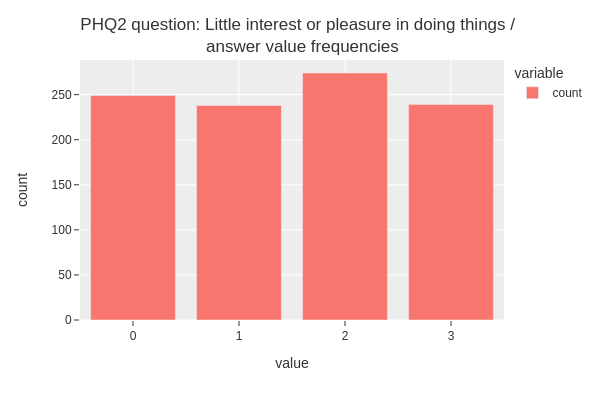

In [8]:
fig = categorical.questionnaire_summary(num_df, 
                                        question = 'PHQ2_1',
                                        title='PHQ2 question: Little interest or pleasure in doing things / <br> answer value frequencies', 
                                        xlabel='value',
                                        ylabel='count',
                                        width=600,
                                        height=400)
fig.show()

The figure shows that the answer values (from 0 to 3) almost uniform in distribution.

## 1.2. Questionnaire grouped summary <a class="anchor" id="section_1_2"></a>

We can also display the summary for each subgroup (*gender*).

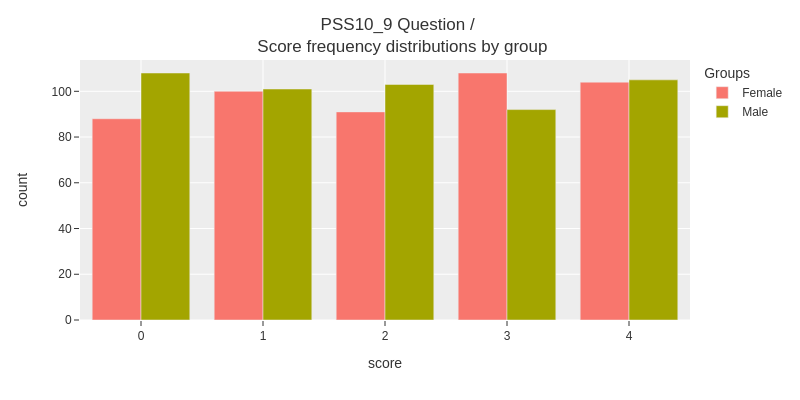

In [9]:
fig = categorical.questionnaire_grouped_summary(num_df, 
                                                question='PSS10_9', 
                                                group='gender', 
                                                title='PSS10_9 Question / <br> Score frequency distributions by group',
                                                xlabel='score',
                                                ylabel='count',
                                                width=800,
                                                height=400)
fig.show()

The figure shows that the differences between subgroups are not very large.

## 1.3. Questionnaire grouped summary score distribution <a class="anchor" id="section_1_3"></a>

With some quick preprocessing, we can display the score distribution of each questionaire.

We'll extract *PSS-10* questionnaire answers from the dataframe, using the `sum_survey_scores` function from the `niimpy.preprocessing.survey` module, and set the gender variable from the original dataframe.

In [10]:
sum_df = sum_survey_scores(num_df, ["PSS10"])
sum_df["gender"] = num_df["gender"]
sum_df.head()

,user,PSS10,gender
0,1,15,Male
1,2,9,Male
2,3,12,Male
3,4,16,Female
4,5,14,Male


And then visualize aggregated summary score distributions, grouped by gender:

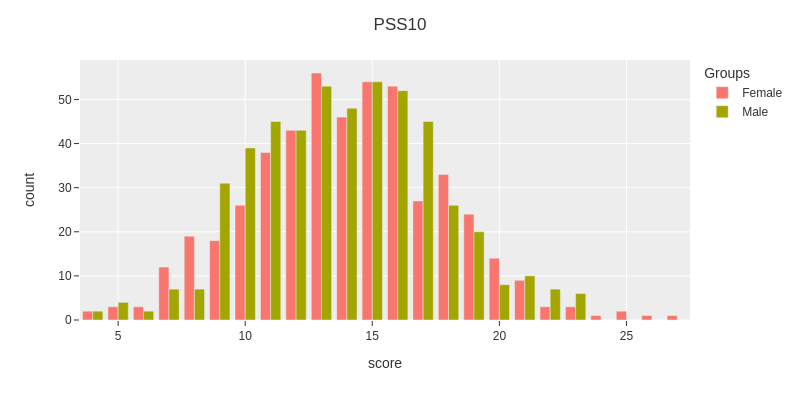

In [11]:
fig = categorical.questionnaire_grouped_summary(sum_df, 
                                                question='PSS10', 
                                                group='gender', 
                                                title='PSS10',
                                                xlabel='score', 
                                                ylabel='count',
                                                width=800, 
                                                height=400)
fig.show()

The figure shows that the grouped summary score distrubutions are close to each other.

## 2) Countplot <a class="anchor" id="section_2"></a>
This section introduces Countplot module. The module contain functions for user and group level observation count (number of datapoints per user or group) visualization and observation value distributions.<br>
Observation counts use barplots for user level and a boxplots for group level visualizations. Boxplots are used for group level value distributions.<br>
The module assumes that the visualized **data is numerical**.

### Data
We will use sample from <a href="https://studentlife.cs.dartmouth.edu/dataset.html">StudentLife dataset</a> to demonstrate the module functions. The sample contains hourly aggregated activity data (values from 0 to 5, where 0 corresponds to no activity, and 5 to high activity) and group information based on pre- and post-study PHQ-9 test scores. Study subjects have been grouped by the depression symptom severity into groups: *none*, *mild*, *moderate*, *moderately severe*, and *severe*. Preprocessed data sample is included in the Niimpy toolbox *sampledata* folder.

In [12]:
# Load data
sl = niimpy.read_csv(config.SL_ACTIVITY_PATH, tz='Europe/Helsinki')
sl.set_index('timestamp',inplace=True)
sl.index = pd.to_datetime(sl.index)
sl_loc = sl.tz_localize(None)

In [13]:
sl_loc.head()

,user,activity,group
timestamp,,,
2013-03-27 06:00:00,u00,2,none
2013-03-27 07:00:00,u00,1,none
2013-03-27 08:00:00,u00,2,none
2013-03-27 09:00:00,u00,3,none
2013-03-27 10:00:00,u00,4,none


Before visualizations, we'll inspect the data.

In [14]:
sl_loc.describe()

,activity
count,55907.000000
mean,0.750264
std,1.298238
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,5.000000


In [15]:
sl_loc.group.unique()

array(['none', 'severe', 'mild', 'moderately severe', 'moderate'],
      dtype=object)

## 2.1. User level observation count <a class="anchor" id="section_2_1"></a>
At first we visualize the number of observations for each subject.

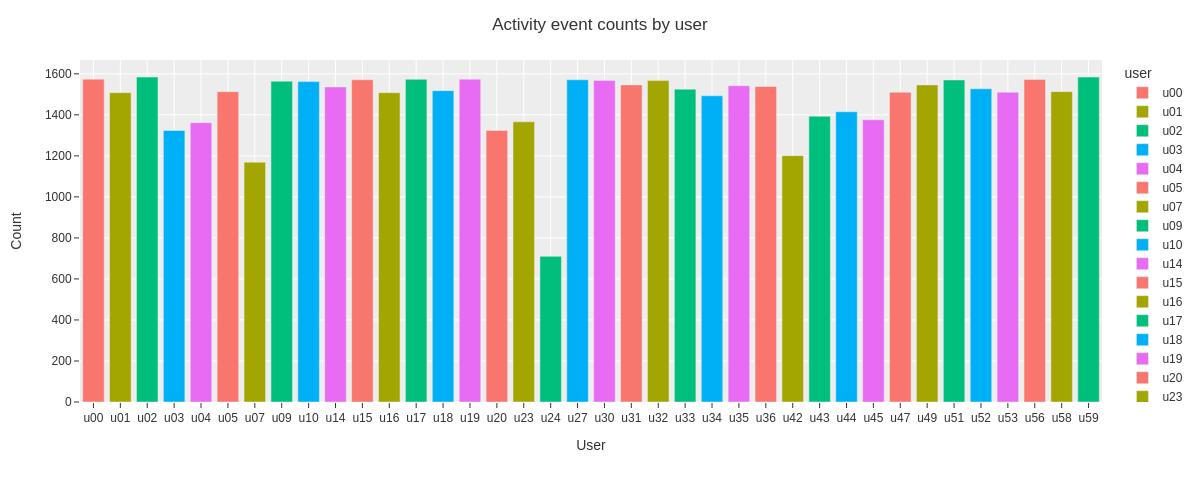

In [16]:
fig = countplot.countplot(sl, 
                          fig_title='Activity event counts by user', 
                          plot_type='count', 
                          points='all',
                          aggregation='user', 
                          user=None, 
                          column=None,
                          binning=False)

fig.show()

The barplot shows that there are differences in user total activity counts. The user *u24* has the lowest event count of 710 and users *u02* and *u59* have the highest count of 1584.

## 2.2. Group level observation count <a class="anchor" id="section_2_2"></a>
Next we'll inspect group level daily activity event count distributions by using boxplots. For the improved clarity, we select a timerange of one week from the data.

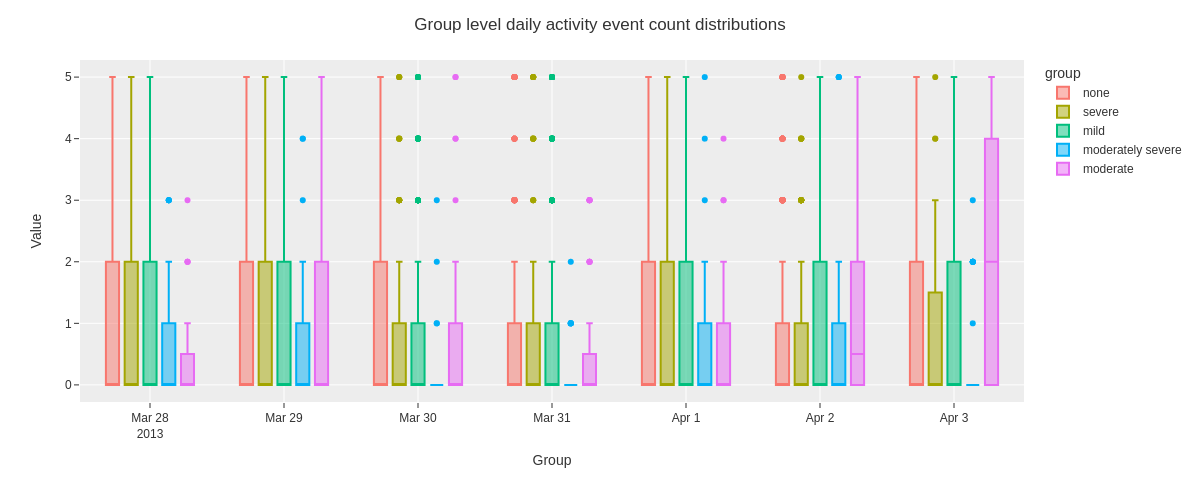

In [17]:
sl_one_week = sl_loc.loc['2013-03-28':'2013-4-3']

fig = countplot.countplot(sl_one_week, 
                          fig_title='Group level daily activity event count distributions', 
                          plot_type='value', 
                          points='all',
                          aggregation='group', 
                          user=None, 
                          column='activity',
                          binning='D')

fig.show()

The boxplot shows some variability in group level event count distributions across the days spanning from Mar 28 to Apr 3 2013.

## 2.3. Group level value distributions <a class="anchor" id="section_2_3"></a>
Finally we visualize group level activity value distributions for whole time range.

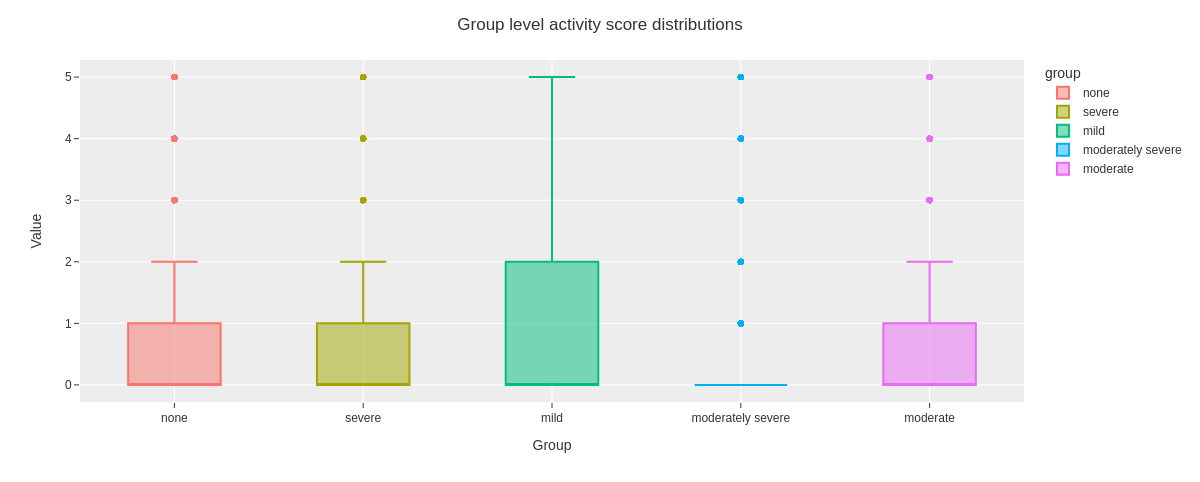

In [18]:
fig = countplot.countplot(sl,
                          fig_title='Group level activity score distributions', 
                          plot_type='value', 
                          points='outliers',
                          aggregation='group', 
                          user=None,
                          column='activity',
                          binning=False)

fig.show()

The boxplot shows that activity score distribution for groups *mild* and *moderately severe* differ from the rest.

## 3. Lineplot <a class="anchor" id="section_3"></a>


This section introduces Lineplot module functions. We use the same <a href="https://studentlife.cs.dartmouth.edu/dataset.html">StudentLife dataset</a> derived activity data as in previous section.

## 3.1. Lineplot <a class="anchor" id="section_3_1"></a>

Lineplot functions display **numerical feature values** on time axis. The user can optionally resample (downsample) and smoothen the data for better visual clarity.

## 3.1.1. Single user single feature <a class="anchor" id="section_3_1_1"></a>
At first, we'll visualize single user single feature data, without resampling or smoothing. 

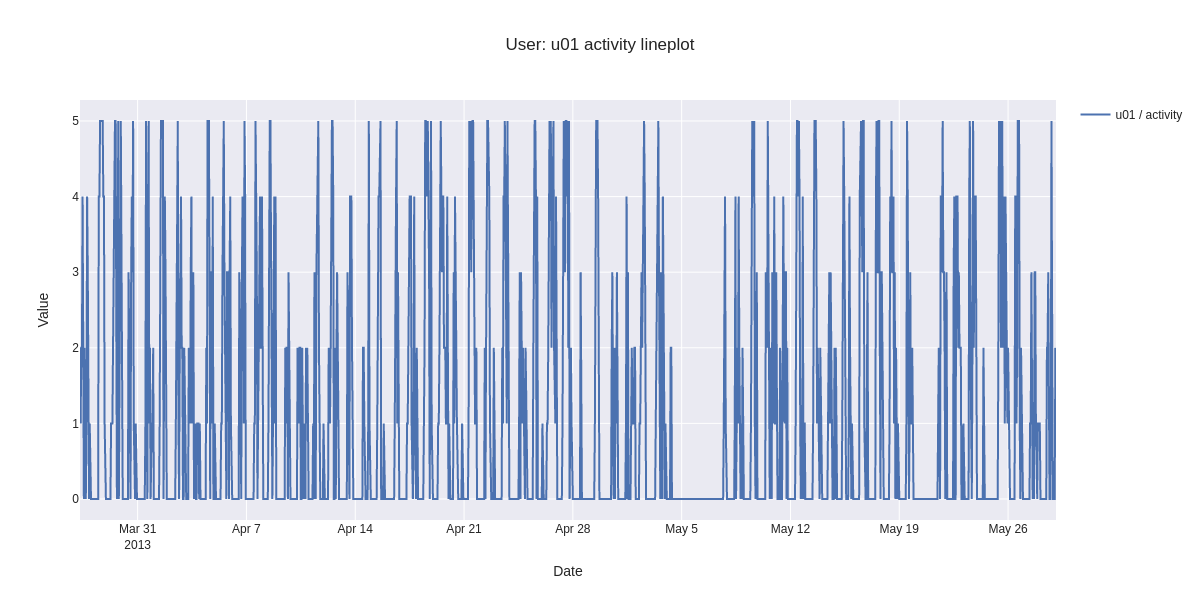

In [19]:
fig = lineplot.timeplot(sl_loc,
                        users=['u01'],
                        columns=['activity'],
                        title='User: {} activity lineplot'.format('u01'),
                        xlabel='Date',
                        ylabel='Value',
                        resample=False,
                        interpolate=False,
                        window=1,
                        reset_index=False)

fig.show()

The figure showing all the activity datapoints is difficult to interpet. By zooming in the time range, the daily patters come apparent. There is no or low activity during the night.

## 3.1.2. Single user single feature index resetted <a class="anchor" id="section_3_1_2"></a>
Next, we'll plot visualize the same data using resampling by hour, and 24 hour rolling window smoothing for improved visualization clarity. We also reset the index, showing now hours from the first activity feature observation.

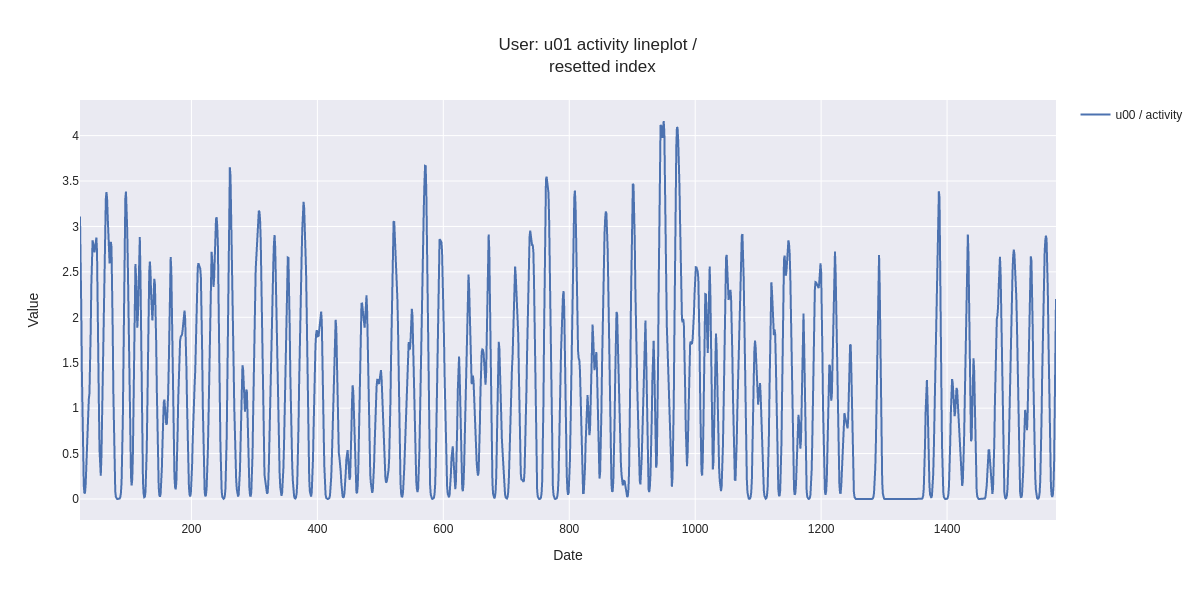

In [20]:
fig = lineplot.timeplot(sl_loc,
                        users=['u00'],
                        columns=['activity'],
                        title='User: {} activity lineplot / <br> resetted index'.format('u01'),
                        xlabel='Date',
                        ylabel='Value',
                        resample='H',
                        interpolate=True,
                        window=24,
                        reset_index=True)

fig.show()

By zooming in the smoothed lineplot, daily activity patterns are easier to detect.

## 3.1.3. Single user single feature, aggregated by day <a class="anchor" id="section_3_1_3"></a>
Next visualization shows resamplig by day and 7 day rolling window smoothing, making the activity time series trend visible.   

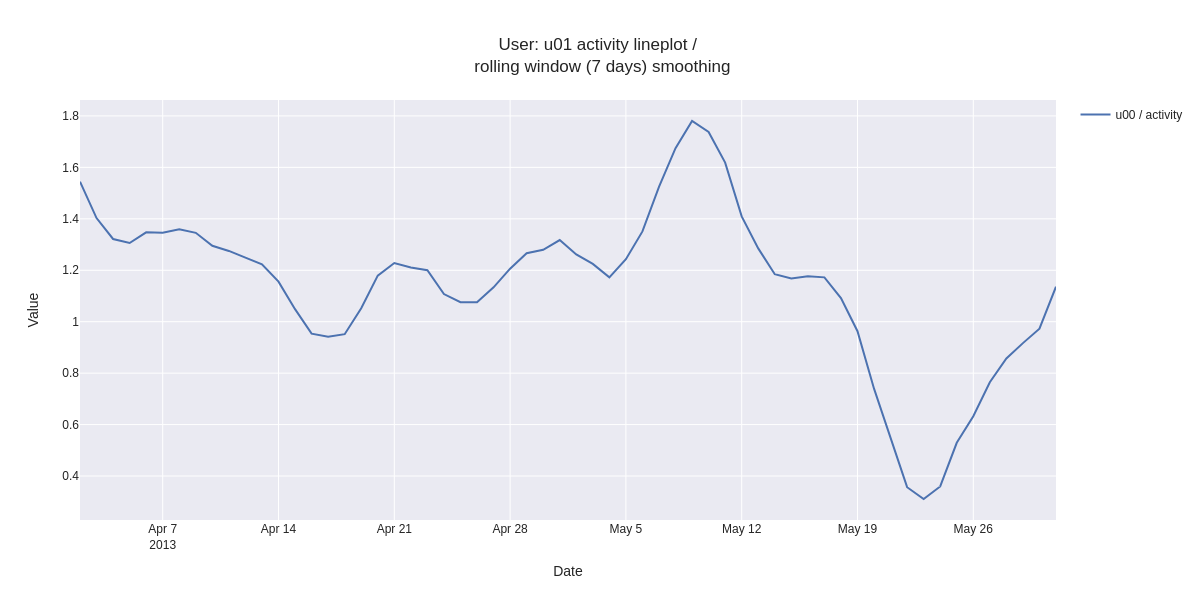

In [21]:
fig = lineplot.timeplot(sl_loc,
                        users=['u00'],
                        columns=['activity'],
                        title='User: {} activity lineplot / <br> rolling window (7 days) smoothing'.format('u01'),
                        xlabel='Date',
                        ylabel='Value',
                        resample='D',
                        interpolate=True,
                        window=7)

fig.show()

Daily aggregated and smoothed data makes the user activity trend visible. There is a peak at May 9 and the crest at May 23.

## 3.2. Multiple subjects single feature <a class="anchor" id="section_3_2"></a>
The following visualization superimposes three subject's activity on same figure. 

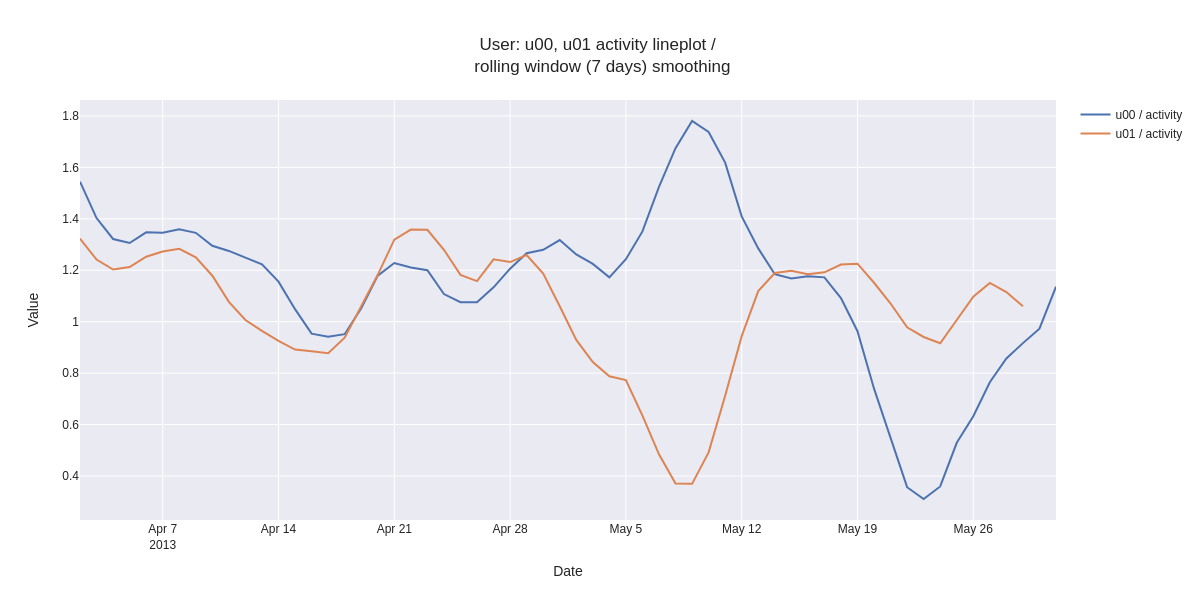

In [22]:
fig = lineplot.timeplot(sl_loc,
                        users=['u00','u01'],
                        columns=['activity'],
                        title='User: {}, {} activity lineplot / <br> rolling window (7 days) smoothing'.format('u00','u01'),
                        xlabel='Date',
                        ylabel='Value',
                        resample='D',
                        interpolate=True,
                        window=7)

fig.show()

The figure shows that the user daily averaged activity is quite similar in the beginning of inspected time range. In first two weeks of May, the activity shows opposing trends (user *u00* activity increases and user *u01* decreases). 

## 3.3. Group level hourly averages <a class="anchor" id="section_3_3"></a>
Next we'll compare group level hourly average activity.

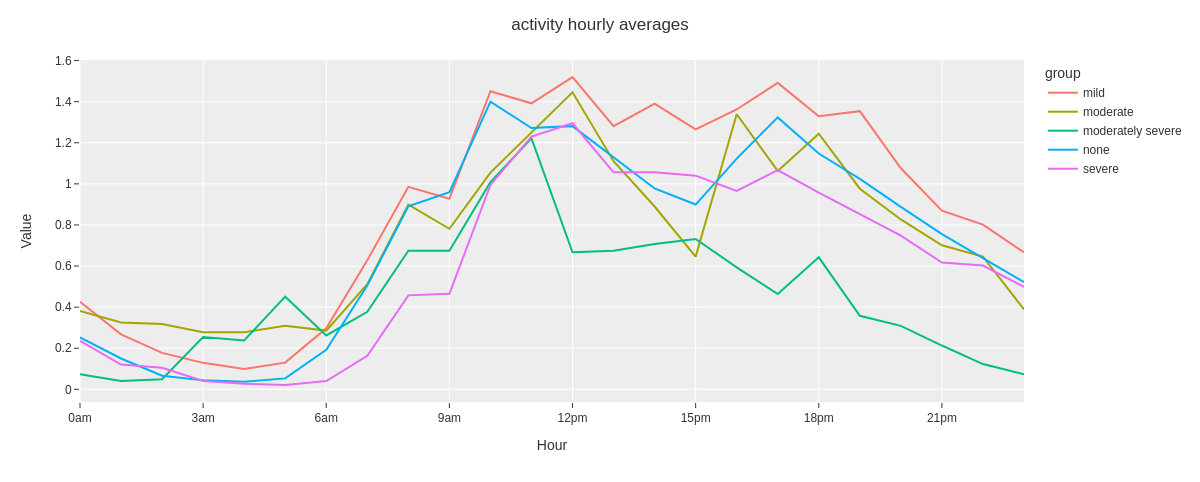

In [23]:
fig = lineplot.timeplot(sl_loc,
                        users='Group',
                        columns=['activity'],
                        title='User group activity / <br> hourly averages',
                        xlabel='Date',
                        ylabel='Value',
                        resample='D',
                        interpolate=True,
                        window=7,
                        reset_index=False,
                        by='hour')

fig.show()

The time plot reveals that the hourly averaged group level activity follows circadian rhytmn (less activity during the night). Moderately severe group seems to be least active group during the latter half of the day. 

## 3.4. Group level weekday averages <a class="anchor" id="section_3_4"></a>
And finally, 

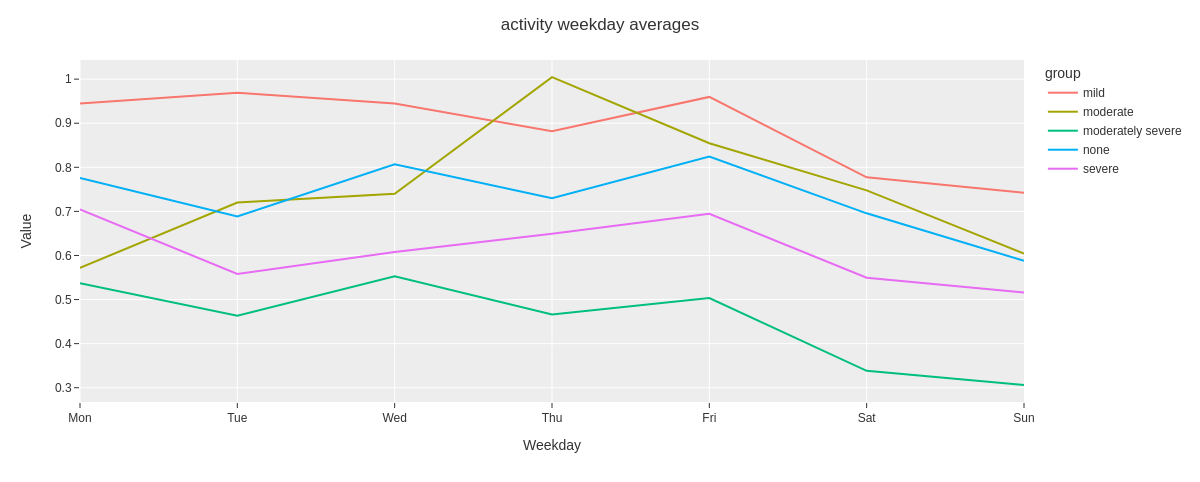

In [24]:
fig = lineplot.timeplot(sl_loc,
                        users='Group',
                        columns=['activity'],
                        title='User Activity',
                        xlabel='Date',
                        ylabel='Value',
                        resample='D',
                        interpolate=True,
                        window=7,
                        reset_index=False,
                        by='weekday')

fig.show()

The timeplot shows that there is some differences between the average group level activity, e.g., group *mild* being more active than *moderately severe*. Additionally, activity during Sundays is at lower level in comparison with weekdays.

## 4. Punchcard <a class="anchor" id="section_4"></a>
This section introduces Punchcard module functions. The functions aggregate the data and show the averaged value for each timepoint. <br> We use the same StudentLife dataset derived activity data as in two previous sections.

## 4.1. Single user punchcard <a class="anchor" id="section_4_1"></a>
At first we visualize one daily aggregated mean activity for single subject. We'll change the plot color to grayscale for improved clarity.


In [25]:
px.defaults.color_continuous_scale = px.colors.sequential.gray

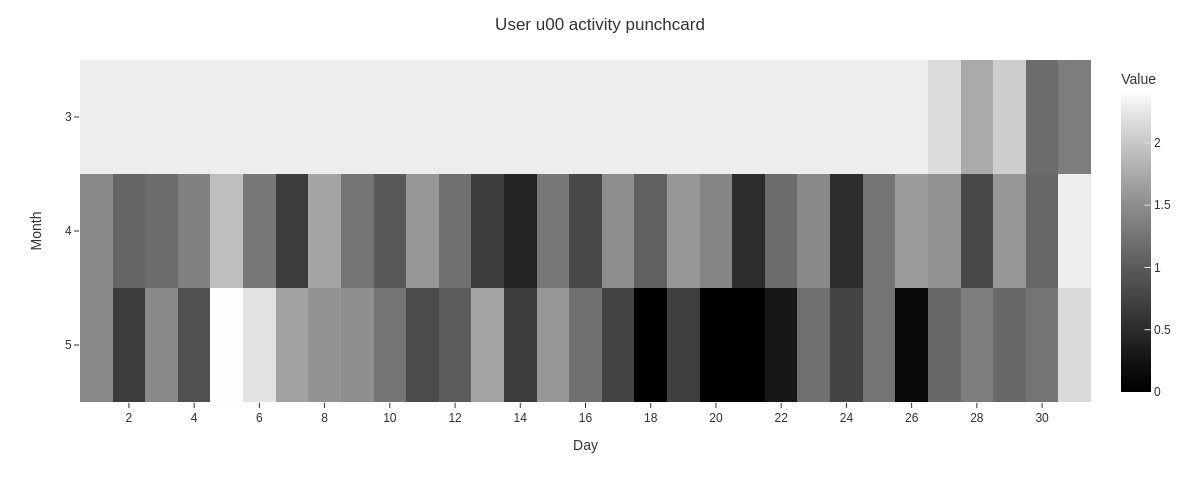

In [26]:
fig = punchcard.punchcard_plot(sl, 
                               user_list=['u00'],
                               columns=['activity'],
                               title="User {} activity punchcard".format('u00'),
                               resample='D',
                               normalize=False,
                               agg_func=np.mean,
                               timerange=False)

fig.show()

The punchcard reveals that May 5th has the highest average activity and May 18th, 20th, and 21th have the lowest activity.  

## 4.2. Multiple user punchcard <a class="anchor" id="section_4_2"></a>
Next, we'll visualize mean activity for multiple subjects.

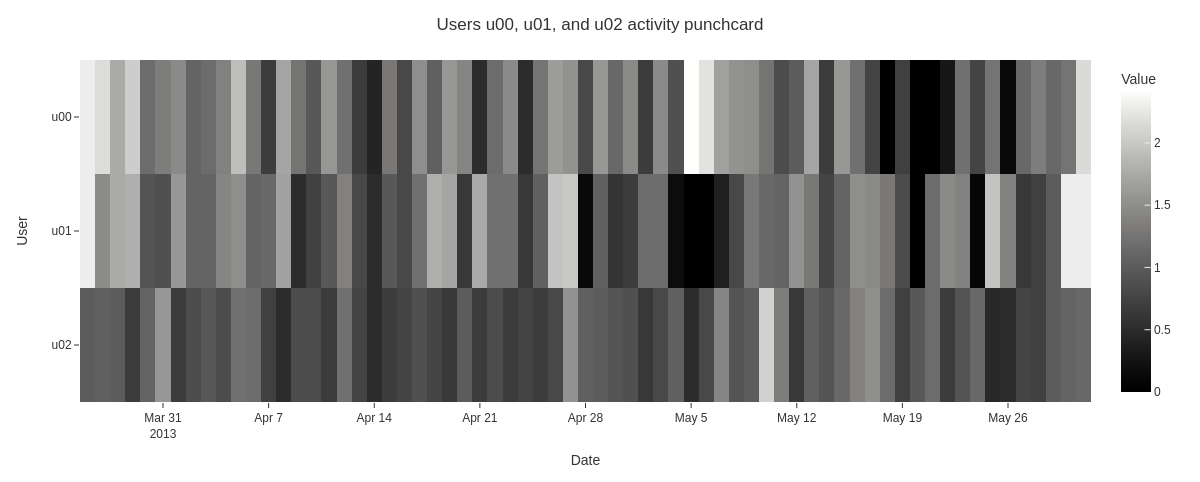

In [27]:
fig = punchcard.punchcard_plot(sl, 
                               user_list=['u00','u01','u02'],
                               columns=['activity'],
                               title="Users {}, {}, and {} activity punchcard".format('u00','u01','u02'),
                               resample='D',
                               normalize=False,
                               agg_func=np.mean,
                               timerange=False)

fig.show()

The punchard allows comparison of daily average activity for multiple subjects. It seems that there is not evident common pattern in the activity.

## 4.3. Single user punchcard showing two features <a class="anchor" id="section_4_3"></a>
Lastly, we'll visualize daily aggregated single user activity side by side with activity of previous week. <br>
We start by shifting the activity by one week and by adding it to the original dataframe. 

In [28]:
sl_loc['previous_week_activity'] = sl_loc['activity'].shift(periods=7, fill_value=0)

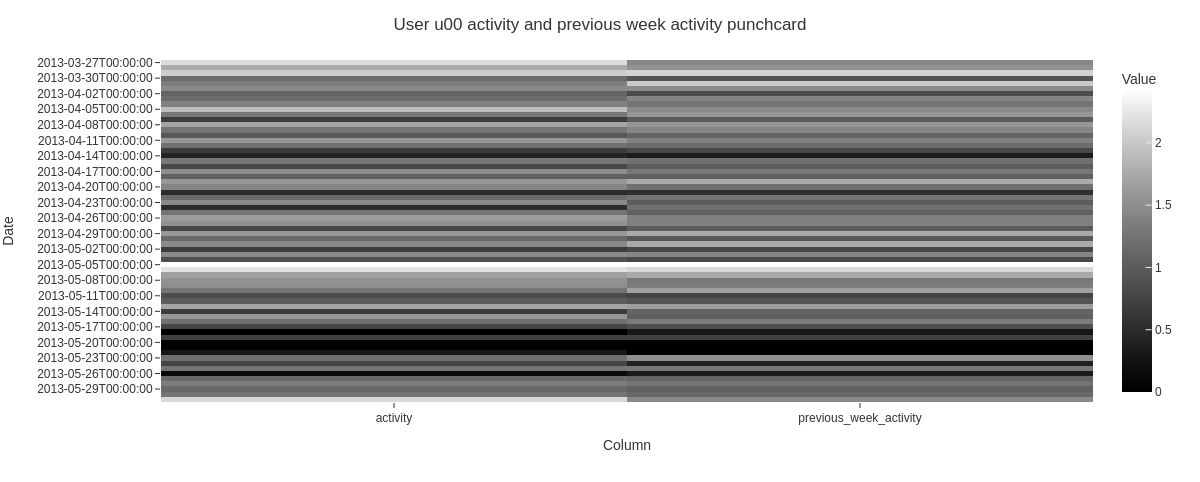

In [29]:
fig = punchcard.punchcard_plot(sl_loc, 
                               user_list=['u00'],
                               columns=['activity','previous_week_activity'],
                               title="User {} activity and previous week activity punchcard".format('u00'),
                               resample='D',
                               normalize=False,
                               agg_func=np.mean,
                               timerange=False)

fig.show()

The punchcard show weekly repeating patterns in subjects activity.

## 5) Missingness <a class="anchor" id="section_5"></a>
This sections introduces Missingness module for missing data inspection. The module features data missingness visualizations by frequency and by timepoint.<br>
Additionally, it offers an option for missing data correlation visualization.   

### Data 

For data missingness visualizations, we'll create a mock dataframe with missing values using `niimpy.util.create_missing_dataframe` function.

In [30]:
df_m = setup_dataframe.create_missing_dataframe(nrows=2*24*14, ncols=5, density=0.7, index_type='dt', freq='10T')
df_m.columns = ['User_1','User_2','User_3','User_4','User_5',]

We will quickly inspect the dataframe before the visualizations.

In [31]:
df_m

,User_1,User_2,User_3,User_4,User_5
2022-01-01 00:00:00,50.155983,NaN,9.188559,NaN,NaN
2022-01-01 00:10:00,48.659226,42.223903,NaN,73.070434,NaN
2022-01-01 00:20:00,70.402707,NaN,91.278417,NaN,95.866591
2022-01-01 00:30:00,34.808220,47.197458,54.421711,64.834840,56.902275
2022-01-01 00:40:00,32.363338,NaN,73.796891,NaN,NaN
...,...,...,...,...,...
2022-01-05 15:10:00,NaN,NaN,8.988024,NaN,93.383961
2022-01-05 15:20:00,81.907111,18.542904,83.963266,86.723864,64.187250
2022-01-05 15:30:00,NaN,NaN,NaN,80.762970,86.918652
2022-01-05 15:40:00,72.521225,27.787159,72.438761,72.761065,87.003308


In [32]:
df_m.describe()

,User_1,User_2,User_3,User_4,User_5
count,472.000000,452.000000,484.000000,464.000000,480.000000
mean,49.656674,51.079783,51.437606,49.906807,52.990859
std,28.296408,28.696666,28.824854,27.217444,28.246868
min,1.537513,1.099729,1.469202,1.431989,1.001682
25%,25.525105,26.037915,26.268606,28.290728,29.926207
50%,49.071085,50.917371,51.383698,47.820825,53.303212
75%,73.380861,75.360156,76.796016,72.831134,78.412972
max,99.736586,99.866813,99.977263,99.929113,99.881642


## 5.1. Data frequency by feature <a class="anchor" id="section_5_1"></a>

First, we create a histogram to visualize data frequency per column. Here, frequency of 1 indicates no missing data points and 0 that all data points are missing.

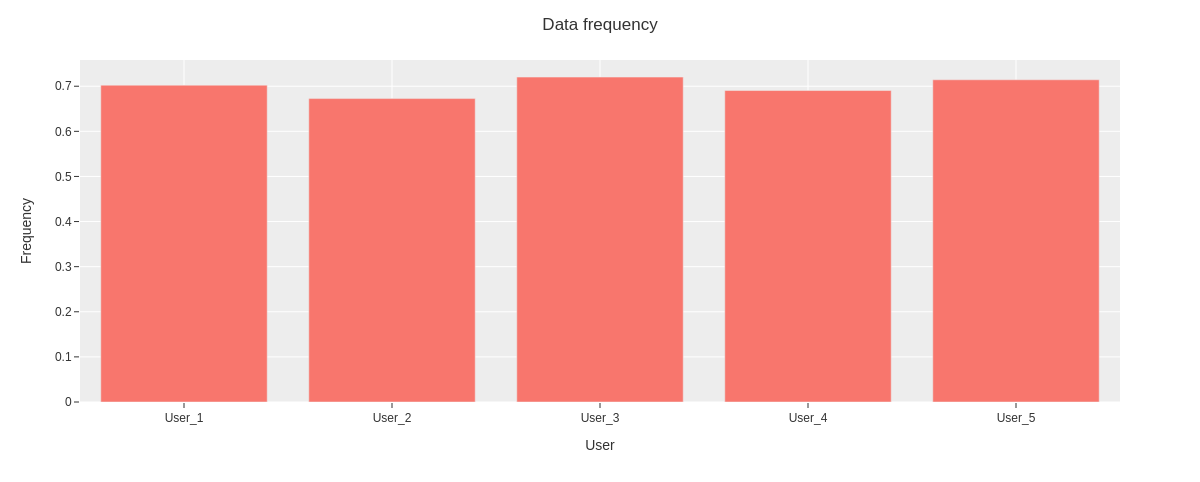

In [33]:
fig = missingness.bar(df_m,
                      xaxis_title='User',
                      yaxis_title='Frequency')
fig.show()

The data frequency is nearly similar for each user, *User_5* having the highest frequency.

## 5.2. Average frequency by user <a class="anchor" id="section_5_2"></a>
Next, we will show average data frequency for all users.

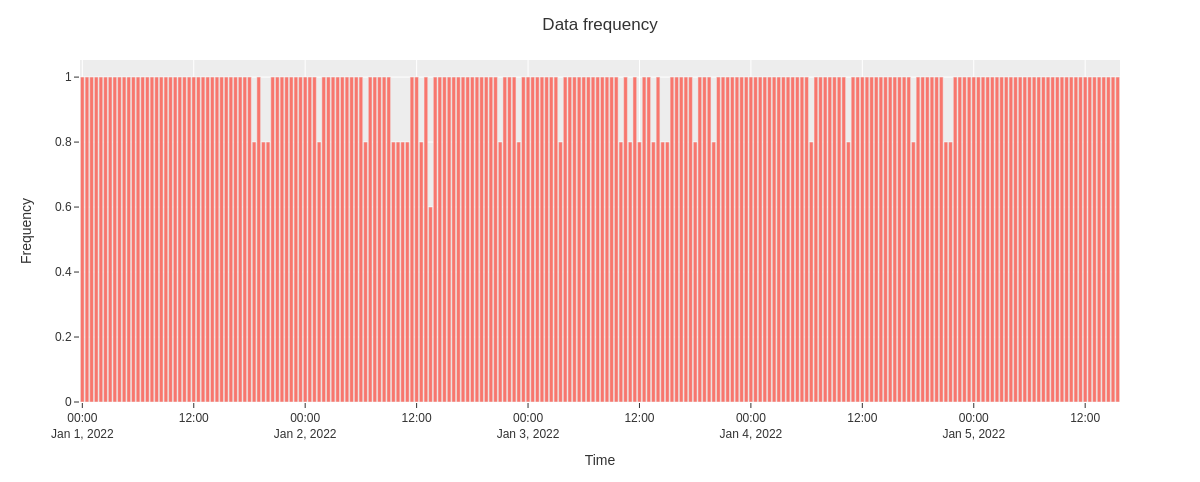

In [34]:
fig = missingness.bar(df_m, 
                      sampling_freq='30T',
                      xaxis_title='Time',
                      yaxis_title='Frequency')
fig.show()

The overall data frequency suggests no clear pattern for data missingness.

## 5.3. Missingness matrix <a class="anchor" id="section_5_3"></a>
We can also create a missingness matrix visualization for the dataframe. The nullity matrix show data missingess by a timepoint.

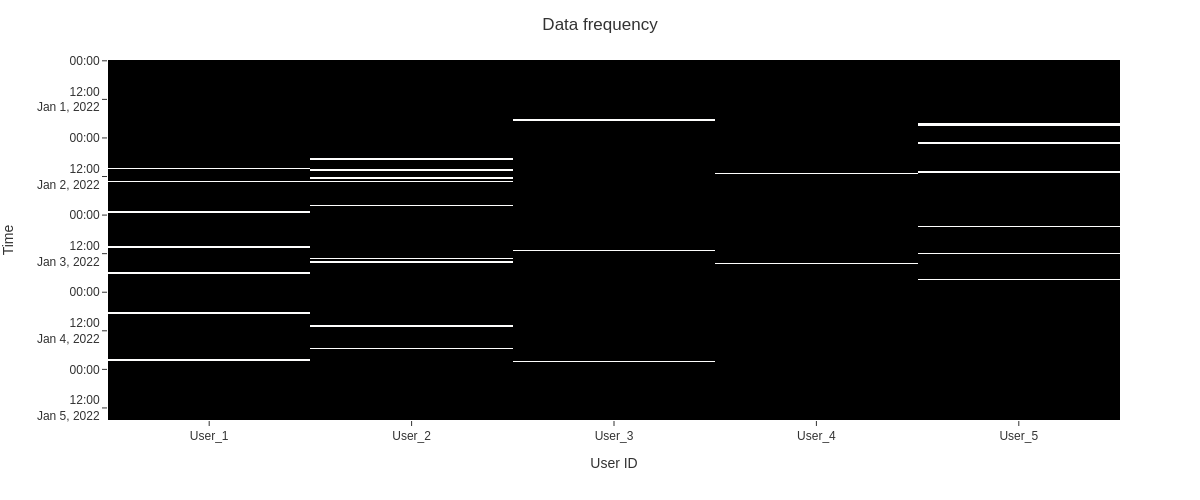

In [35]:
fig = missingness.matrix(df_m,
                         sampling_freq='30T',
                         xaxis_title="User ID",
                         yaxis_title="Time")
fig.show()

## 5.4. Missing data correlations <a class="anchor" id="section_5_4"></a>

Finally, we plot a heatmap to display the correlations between missing data.

Correlation ranges from -1 to 1: 
* -1 means that if one variable appears then the other will be missing. 
* 0 means that there is no correlation between the missingness of two variables. 
* 1 means that the two variables will always appear together.

### Data
For the correlations, we use *NYC collision factors* [sample data](https://github.com/ResidentMario/missingno). 

In [36]:
collisions = pd.read_csv("https://raw.githubusercontent.com/ResidentMario/missingno-data/master/nyc_collision_factors.csv")

First, we'll inspect the data frame.

In [37]:
collisions.head()

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,11/10/2016,16:11:00,BROOKLYN,11208.0,40.662514,-73.872007,"(40.6625139, -73.8720068)",WORTMAN AVENUE,MONTAUK AVENUE,NaN,...,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,TAXI,PASSENGER VEHICLE,NaN,NaN,NaN
1,11/10/2016,05:11:00,MANHATTAN,10013.0,40.721323,-74.008344,"(40.7213228, -74.0083444)",HUBERT STREET,HUDSON STREET,NaN,...,Failure to Yield Right-of-Way,NaN,NaN,NaN,NaN,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
2,04/16/2016,09:15:00,BROOKLYN,11201.0,40.687999,-73.997563,"(40.6879989, -73.9975625)",HENRY STREET,WARREN STREET,NaN,...,Lost Consciousness,Lost Consciousness,NaN,NaN,NaN,PASSENGER VEHICLE,VAN,NaN,NaN,NaN
3,04/15/2016,10:20:00,QUEENS,11375.0,40.719228,-73.854542,"(40.7192276, -73.8545422)",NaN,NaN,67-64 FLEET STREET,...,Failure to Yield Right-of-Way,Failure to Yield Right-of-Way,Failure to Yield Right-of-Way,NaN,NaN,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN
4,04/15/2016,10:35:00,BROOKLYN,11210.0,40.632147,-73.952731,"(40.6321467, -73.9527315)",BEDFORD AVENUE,CAMPUS ROAD,NaN,...,Failure to Yield Right-of-Way,Failure to Yield Right-of-Way,NaN,NaN,NaN,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN


In [38]:
collisions.dtypes

DATE                              object
TIME                              object
BOROUGH                           object
ZIP CODE                         float64
LATITUDE                         float64
LONGITUDE                        float64
LOCATION                          object
ON STREET NAME                    object
CROSS STREET NAME                 object
OFF STREET NAME                   object
NUMBER OF PERSONS INJURED          int64
NUMBER OF PERSONS KILLED           int64
NUMBER OF PEDESTRIANS INJURED      int64
NUMBER OF PEDESTRIANS KILLED       int64
NUMBER OF CYCLISTS INJURED       float64
NUMBER OF CYCLISTS KILLED        float64
CONTRIBUTING FACTOR VEHICLE 1     object
CONTRIBUTING FACTOR VEHICLE 2     object
CONTRIBUTING FACTOR VEHICLE 3     object
CONTRIBUTING FACTOR VEHICLE 4     object
CONTRIBUTING FACTOR VEHICLE 5     object
VEHICLE TYPE CODE 1               object
VEHICLE TYPE CODE 2               object
VEHICLE TYPE CODE 3               object
VEHICLE TYPE COD

We will then inspect the basic statistics.

In [39]:
collisions.describe()

,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLISTS INJURED,NUMBER OF CYCLISTS KILLED
count,6919.000000,7303.000000,7303.000000,7303.000000,7303.000000,7303.000000,7303.000000,0.0,0.0
mean,10900.746640,40.717653,-73.921406,0.350678,0.000959,0.133644,0.000822,NaN,NaN
std,551.568724,0.069437,0.083317,0.707873,0.030947,0.362129,0.028653,NaN,NaN
min,10001.000000,40.502341,-74.248277,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,10310.000000,40.670865,-73.980744,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,11211.000000,40.723260,-73.933888,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,11355.000000,40.759527,-73.864463,1.000000,0.000000,0.000000,0.000000,NaN,NaN
max,11694.000000,40.909628,-73.702590,16.000000,1.000000,3.000000,1.000000,NaN,NaN


Finally, we will visualize the nullity (how strongly the presence or absence of one variable affects the presence of another) correlations by a heatmap and a dendrogram.

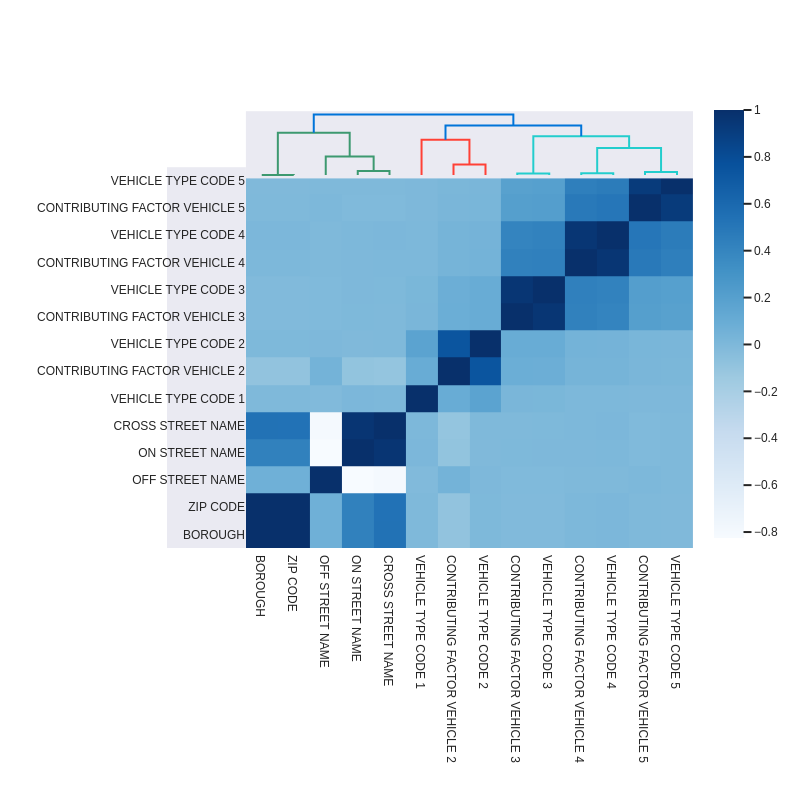

In [40]:
fig = missingness.heatmap(collisions)
fig.show()

The nullity heatmap and dendrogram reveals a data correlation structure, e.g., *vehicle type codes* and *contributing factor vehicle* are highly correlated. Features having complete data are not shown on the figure.